<br>

<h1 align="center">
  <img src="https://github.com/najwasaeed44/data-science-project-theme/blob/main/img/logo.png?raw=true" width="200px"/><br/>
Voice Cloning and Fake Audio Detection
</h1>


<hr style="height:4px;border-width:10;color:blue;background-color:black">



### Part **2: THE CLASSIFIER**

to classify real and fake audio, the classifier will be tested on two form of audio data.

1) Real audio data VS. Cloned audio data.

2) Real audio data VS. Cloned audio data with removing the noise.

    Let's download the common voice dataset and move a 400 audio files to drive to asve the time.

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download mozillaorg/common-voice
!unzip /content/common-voice.zip

In [50]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

In [51]:
import os
import random
import shutil
import librosa 
import numpy as np
import pandas as pd




import warnings
warnings.filterwarnings("ignore")

In [ ]:
files_list = []

for root, dirs, files in os.walk("/content/cv-other-test/cv-other-test"):
    for file in files:
        if file.endswith(".mp3") :
            files_list.append(os.path.join(root, file))

# print files_list   
filesToCopy = random.sample(files_list, 400)  #prints two random files from list 

destPath = "/content/drive/MyDrive/real_audio"


# iteraate over all random files and move them
for file in filesToCopy:
    shutil.move(file, destPath)

    Let's see the fake audios...

# 1) Real audio data VS. Cloned audio data

In [5]:
fake_file_list = os.listdir('/content/drive/MyDrive/synthesized_audio_long_version') 
#read them into pandas
fake_df = pd.DataFrame(fake_file_list)
# Renaming the column name to file
fake_df = fake_df.rename(columns={0:'file'})
fake_df['real'] = 0
fake_df.file = [f"/content/drive/MyDrive/synthesized_audio_long_version/{i}" for i in fake_df.file]
fake_df.head(2)

,file,real
0,/content/drive/MyDrive/synthesized_audio_long_...,0
1,/content/drive/MyDrive/synthesized_audio_long_...,0


    And the real ones
    

In [6]:
#list the files
real_file_list = os.listdir("/content/drive/MyDrive/real_audio") 
#read them into pandas
real_df = pd.DataFrame(real_file_list)
# Renaming the column name to file
real_df = real_df.rename(columns={0:'file'})
real_df['real'] = 1
real_df.file = [f"/content/drive/MyDrive/real_audio/{i}" for i in real_df.file]
real_df.head(2)

,file,real
0,/content/drive/MyDrive/real_audio/sample-00001...,1
1,/content/drive/MyDrive/real_audio/sample-00000...,1


In [7]:
real_df.shape, fake_df.shape

((400, 2), (336, 2))

In [8]:
df = pd.concat([real_df, fake_df], axis=0)
df.head(2)

,file,real
0,/content/drive/MyDrive/real_audio/sample-00001...,1
1,/content/drive/MyDrive/real_audio/sample-00000...,1


In [9]:
df.shape

(736, 2)

In [10]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,file,real
0,/content/drive/MyDrive/real_audio/sample-00037...,1
1,/content/drive/MyDrive/real_audio/sample-00257...,1
2,/content/drive/MyDrive/synthesized_audio_long_...,0
3,/content/drive/MyDrive/synthesized_audio_long_...,0
4,/content/drive/MyDrive/real_audio/sample-00268...,1


    Split the files into train, test and val.

In [11]:
from sklearn.model_selection import train_test_split
X = df[['file']]
y = df.real
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=True)


print(f"X_train length is: {len(X_train)}, y_train length is: {len(y_train)}")
print(f"X_test length is: {len(X_test)}, y_test length is: {len(y_test)}")
print(f"X_val length is: {len(X_val)}, y_val length is: {len(y_val)}")

X_train length is: 595, y_train length is: 595
X_test length is: 74, y_test length is: 74
X_val length is: 67, y_val length is: 67


To extract the audio features, we will use `extract_features` function...

In [12]:
def extract_features(files):
  """
  return mfccs, chroma, mel, contrast and tonnetz for each audio file
  """
  df = {'mfccs' : [], 'chroma' : [], 'mel' : [], 'contrast' : [], 'tonnetz' : []}
  for file_name in files:
    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    df['mfccs'].append(mfccs)
    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))
    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    df['chroma'].append(chroma)
    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    df['mel'].append(mel)
    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    df['contrast'].append(contrast)
    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    df['tonnetz'].append(tonnetz)
  return df

In [13]:
val_features = extract_features(X_val.file)
train_features = extract_features(X_train.file)
test_features = extract_features(X_test.file)

In [14]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()

    Let's scale all of the features and concatenate them into an array for each audio file by using `concat_features` function.

In [15]:
def concat_features(features):
  features_list = []
  for i in range(0, len(features['mfccs'])):
      features_list.append(np.concatenate((
          scalar.fit_transform((features['mfccs'][i]).reshape(-1, 1)),
          scalar.fit_transform((features['chroma'][i]).reshape(-1, 1)), 
          scalar.fit_transform((features['mel'][i]).reshape(-1, 1)), 
          scalar.fit_transform((features['contrast'][i]).reshape(-1, 1)),
          scalar.fit_transform((features['tonnetz'][i]).reshape(-1, 1))), axis=0))
  return np.array(features_list).reshape(len(features['mfccs']), 193)

In [16]:
X_val_data = concat_features(val_features)
X_train_data = concat_features(train_features)
X_test_data = concat_features(test_features)

In [17]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [18]:
import tensorflow as tf

In [19]:
# 1) create the model
model_1 = tf.keras.Sequential([
                             tf.keras.layers.Dense(units=50, input_shape=(193,), activation='relu'),
                             tf.keras.layers.Dense(units=50, activation='relu'),
                            #  tf.keras.layers.Dense(units=50, activation='relu'), 
                             tf.keras.layers.Dense(units=1, activation='sigmoid')])
# 2) compile the model
model_1.compile(loss='binary_crossentropy', metrics=tf.keras.metrics.AUC(), optimizer='adam')
# 3) fit the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [20]:
hist_1 = model_1.fit(X_train_data, y_train, validation_data=(X_val_data, y_val), epochs=2000, callbacks=[early_stop])

Epoch 1/2000
19/19 [==============================] - 1s 20ms/step - loss: 0.3411 - auc: 0.9508 - val_loss: 0.1987 - val_auc: 0.9799
Epoch 2/2000
19/19 [==============================] - 0s 3ms/step - loss: 0.1188 - auc: 0.9952 - val_loss: 0.1318 - val_auc: 0.9871
Epoch 3/2000
19/19 [==============================] - 0s 5ms/step - loss: 0.0653 - auc: 0.9980 - val_loss: 0.0970 - val_auc: 0.9937
Epoch 4/2000
19/19 [==============================] - 0s 4ms/step - loss: 0.0438 - auc: 0.9991 - val_loss: 0.0842 - val_auc: 0.9964
Epoch 5/2000
19/19 [==============================] - 0s 3ms/step - loss: 0.0295 - auc: 0.9998 - val_loss: 0.0624 - val_auc: 0.9973
Epoch 6/2000
19/19 [==============================] - 0s 4ms/step - loss: 0.0207 - auc: 1.0000 - val_loss: 0.0607 - val_auc: 0.9973
Epoch 7/2000
19/19 [==============================] - 0s 4ms/step - loss: 0.0137 - auc: 1.0000 - val_loss: 0.0545 - val_auc: 0.9982
Epoch 8/2000
19/19 [==============================] - 0s 4ms/step - loss: 0

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


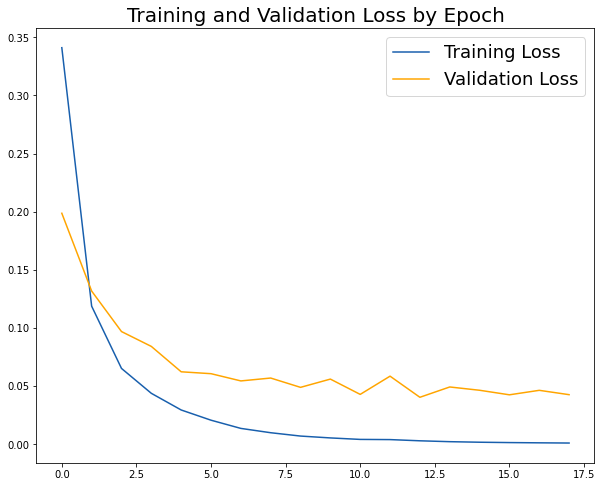

In [22]:
plt.figure(figsize=(10, 8))
# Generate line plot of training, testing loss over epochs.
plt.plot(hist_1.history['loss'], label='Training Loss', color='#185fad')
plt.plot(hist_1.history['val_loss'], label='Validation Loss', color='orange')
# Set title
plt.title('Training and Validation Loss by Epoch', fontsize = 20)
plt.legend(fontsize = 18);

3/3 [==============================] - 0s 4ms/step - loss: 0.0146 - auc: 1.0000
test evaluation [0.014597643166780472, 1.0]


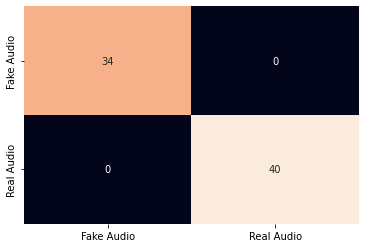

In [23]:
print('test evaluation', model_1.evaluate(X_test_data, y_test))
cm = confusion_matrix(y_test, y_pred=tf.round(model_1.predict(X_test_data)))
ax = sns.heatmap(cm, annot=True, cbar=False)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Fake Audio', 'Real Audio'])
ax.yaxis.set_ticklabels(['Fake Audio', 'Real Audio'])

## Display the visualization of the Confusion Matrix.
plt.show()

---

# 2) Real audio data VS. Cloned audio data with removing the noise.

In [ ]:
!pip install noisereduce

from scipy.io import wavfile
import noisereduce as nr

In [25]:
for file in os.listdir('/content/drive/MyDrive/synthesized_audio_long_version'):
  # load data
  rate, data = wavfile.read(f'/content/drive/MyDrive/synthesized_audio_long_version/{file}')
  # perform noise reduction
  reduced_noise = nr.reduce_noise(y=data, sr=rate)
  wavfile.write(f"/content/drive/MyDrive/synthesized_audio_long_version_without_noise/{file}", rate, reduced_noise)

In [26]:
#list the files
fake_file_list_without_noise = os.listdir('/content/drive/MyDrive/synthesized_audio_long_version_without_noise') 
#read them into pandas
fake_df_without_noise = pd.DataFrame(fake_file_list_without_noise)
# Renaming the column name to file
fake_df_without_noise = fake_df_without_noise.rename(columns={0:'file'})
fake_df_without_noise['real'] = 0
fake_df_without_noise.file = [f"/content/drive/MyDrive/synthesized_audio_long_version_without_noise/{i}" for i in fake_df_without_noise.file]
fake_df_without_noise.head(2)

,file,real
0,/content/drive/MyDrive/synthesized_audio_long_...,0
1,/content/drive/MyDrive/synthesized_audio_long_...,0


In [27]:
df_without_noise = pd.concat([real_df, fake_df_without_noise], axis=0)
df_without_noise = df_without_noise.sample(frac=1).reset_index(drop=True)
df_without_noise.head(2)


,file,real
0,/content/drive/MyDrive/synthesized_audio_long_...,0
1,/content/drive/MyDrive/real_audio/sample-00116...,1


In [28]:
X = df_without_noise[['file']]
y = df_without_noise.real
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=True)


print(f"X_train length is: {len(X_train)}, y_train length is: {len(y_train)}")
print(f"X_test length is: {len(X_test)}, y_test length is: {len(y_test)}")
print(f"X_val length is: {len(X_val)}, y_val length is: {len(y_val)}")

X_train length is: 595, y_train length is: 595
X_test length is: 74, y_test length is: 74
X_val length is: 67, y_val length is: 67


In [29]:
val_features = extract_features(X_val.file)
train_features = extract_features(X_train.file)
test_features = extract_features(X_test.file)

In [30]:
X_val_data = concat_features(val_features)
X_train_data = concat_features(train_features)
X_test_data = concat_features(test_features)

In [65]:
from IPython.display import Audio 

In [59]:
tf.random.set_seed(221)

# 1) create the model
model_2 = tf.keras.Sequential([
                             tf.keras.layers.Dense(units=193, input_shape=(193,), activation='relu'),
                             tf.keras.layers.Dense(units=50, activation='relu'),
                            #  tf.keras.layers.Dense(units=50, activation='relu'), 
                             tf.keras.layers.Dense(units=1, activation='sigmoid')])
# 2) compile the model
model_2.compile(loss='binary_crossentropy', metrics=tf.keras.metrics.AUC(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001))
# 3) fit the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [60]:
hist_3 = model_2.fit(X_train_data, y_train, validation_data=(X_val_data, y_val), epochs=1000, callbacks=[early_stop])

Epoch 1/1000
19/19 [==============================] - 1s 18ms/step - loss: 0.6645 - auc_1: 0.6494 - val_loss: 0.6953 - val_auc_1: 0.6227
Epoch 2/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.6624 - auc_1: 0.6541 - val_loss: 0.6930 - val_auc_1: 0.6273
Epoch 3/1000
19/19 [==============================] - 0s 4ms/step - loss: 0.6603 - auc_1: 0.6594 - val_loss: 0.6906 - val_auc_1: 0.6392
Epoch 4/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.6583 - auc_1: 0.6644 - val_loss: 0.6883 - val_auc_1: 0.6451
Epoch 5/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.6563 - auc_1: 0.6689 - val_loss: 0.6860 - val_auc_1: 0.6557
Epoch 6/1000
19/19 [==============================] - 0s 3ms/step - loss: 0.6543 - auc_1: 0.6736 - val_loss: 0.6837 - val_auc_1: 0.6639
Epoch 7/1000
19/19 [==============================] - 0s 5ms/step - loss: 0.6523 - auc_1: 0.6787 - val_loss: 0.6815 - val_auc_1: 0.6722
Epoch 8/1000
19/19 [===========================

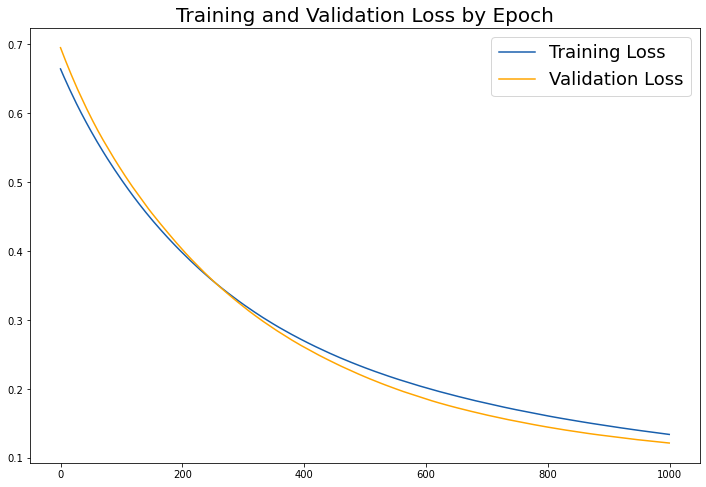

In [61]:
plt.figure(figsize=(12, 8))
# Generate line plot of training, testing loss over epochs.
plt.plot(hist_3.history['loss'], label='Training Loss', color='#185fad')
plt.plot(hist_3.history['val_loss'], label='Validation Loss', color='orange')
# Set title
plt.title('Training and Validation Loss by Epoch', fontsize = 20)
plt.legend(fontsize = 18);

3/3 [==============================] - 0s 3ms/step - loss: 0.1618 - auc_1: 0.9927
test evaluation [0.16178558766841888, 0.9926900863647461]


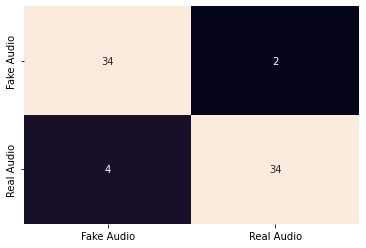

In [62]:
print('test evaluation', model_2.evaluate(X_test_data, y_test))
cm = confusion_matrix(y_test, y_pred=tf.round(model_2.predict(X_test_data)))
ax = sns.heatmap(cm, annot=True, cbar=False)

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Fake Audio', 'Real Audio'])
ax.yaxis.set_ticklabels(['Fake Audio', 'Real Audio'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [63]:
predictions_ = X_test.reset_index(drop=True)
predictions_['y_true'] = y_test
pred = np.round(model_2.predict(X_test_data)).reshape(74,)
predictions_['y_pred'] = pred
predictions_[predictions_.y_true != predictions_.y_pred]

,file,y_true,y_pred
2,/content/drive/MyDrive/real_audio/sample-00290...,1,0.0
16,/content/drive/MyDrive/synthesized_audio_long_...,0,1.0
18,/content/drive/MyDrive/synthesized_audio_long_...,0,1.0
22,/content/drive/MyDrive/real_audio/sample-00260...,1,0.0
29,/content/drive/MyDrive/real_audio/sample-00046...,1,0.0
31,/content/drive/MyDrive/real_audio/sample-00222...,1,0.0


In [66]:
Audio(predictions_.file[2], autoplay=True)

In [67]:
Audio(predictions_.file[16], autoplay=True)

In [68]:
Audio(predictions_.file[18], autoplay=True)

In [69]:
Audio(predictions_.file[22], autoplay=True)

In [70]:
Audio(predictions_.file[29], autoplay=True)

In [71]:
Audio(predictions_.file[31], autoplay=True)